# Importing Libraries

Keras is used as the machine learning engine
OpenVINO for Myriad X is used

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import csv
from pathlib import Path
import IPython.display as ipd
# Analysis
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
#Tensorflow
import tensorflow as tf

import mo_tf
import timeit
from openvino.inference_engine import IECore

2024-02-14 09:22:33.332436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Variables to tune model
These variables are used to tune a model for a specific dataset

In [2]:
# Selected Channel
filename = 'P-3'
# Feature Vector size
window_size = 50
# Number of datapoints to itterate in window generation
stride = 1
# Anomaly Window Threshold percentage
threshold = 0.5
# Number of Training Epochs
epochs = 15
# Percentile to use for reconstruction Error threshold
percentile = 99.99

# Loading and Visualising Train & Test Datasets
Raw Train & Test datasets are leaded as data_train and data_test

In [3]:
path_train = './data/train/' + filename + '.npy'
path_test = './data/test/' + filename + '.npy'

s1 = os.path.getsize(path_train)
s2 = os.path.getsize(path_test)

data_train = np.load(path_train)
data_test = np.load(path_test)

In [4]:
df = pd.DataFrame(data_train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.388888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.499999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.388888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.388888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.388888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Labelled Anomaly File

The anomaly_sequences variable is referenced to the channel selected and pulled out into an array for use later

In [5]:
data = pd.read_csv (r'./labeled_anomalies.csv')
data.head()

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [6]:
# Defining chan_id as index
data.set_index('chan_id', inplace = True)

In [7]:
# Data is loaded in as a string and must be converted to an array
filedata = data.loc[filename, 'anomaly_sequences']
if isinstance(filedata, str) == True:
    test = filedata.split(',')
else:
    test = filedata[0].split(',')

test[1].strip("[]")

counter = 0
anomaly_ranges = []
temp = []
for n in range(0, len(test)):
    temp.append(int(test[n].strip(' [] ')))
    counter += 1
    if counter == 2:
        anomaly_ranges.append(temp)
        temp = []
        counter = 0

print("Total number of labelled anomalies in dataset:", len(anomaly_ranges))
print("Ranges of anomalies: ", anomaly_ranges)

Total number of labelled anomalies in dataset: 1
Ranges of anomalies:  [[5401, 6736]]


In [8]:
custom_ranges = []
custom_ranges.append([5401, 5550])
custom_ranges.append([5760, 6640])
#anomaly_ranges = custom_ranges

# Separating Telemetry data
Spliting Train and Test datasets into readable data only containing first column data

In [9]:
ydata = []
for x in range (0, len(data_train)):
    ydata.append(data_train[x][0])
    
testdata = []
for x in range (0, len(data_test)):
    testdata.append(data_test[x][0])

# Renormalising between 0,1

In [10]:
X_train = np.array(ydata).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
X_train_1D = X_train_norm.ravel()

X_test = np.array(testdata).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_test_norm = scaler.fit_transform(X_test)
X_test_1D = X_test_norm.ravel()

In [11]:
ydata = X_train_1D
testdata = X_test_1D

# Plotting Training and Test datasets
Train & Test data is plotted for visualisation

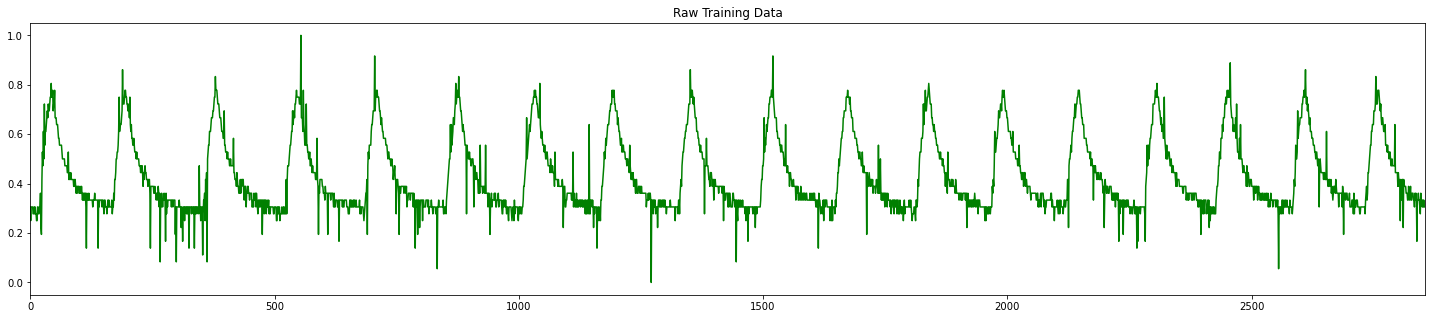

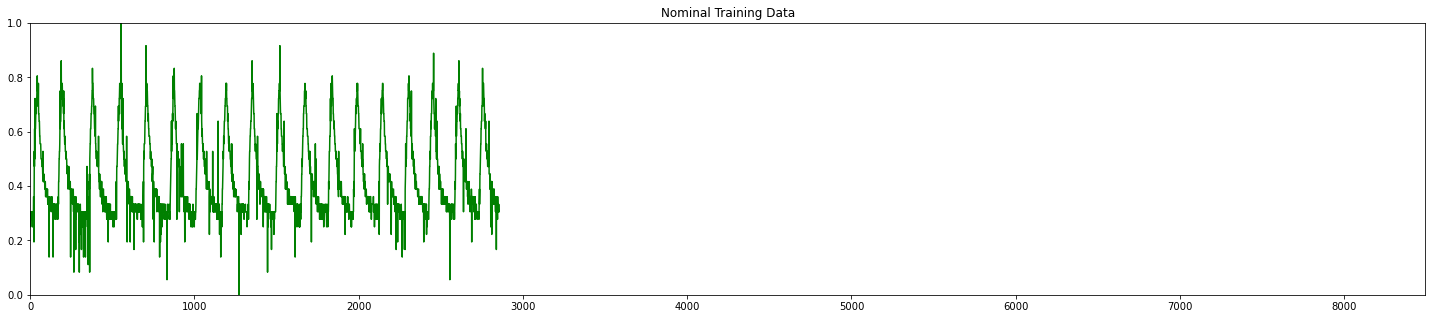

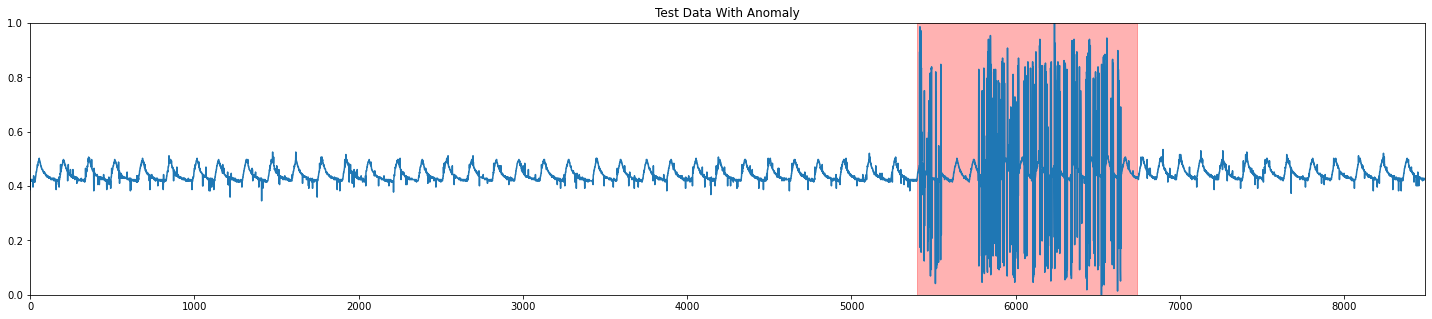

In [12]:
points_train = np.array(ydata)
points_test = np.array(testdata)

plt.figure(figsize=(25, 5))
plt.xlim(0, len(points_train))
plt.plot(points_train, color = 'green')
plt.title("Raw Training Data")
plt.show()

plt.figure(figsize=(25, 5))
plt.ylim(0, 1)
plt.xlim(0, len(points_test))
plt.plot(points_train, color = 'green')
plt.title("Nominal Training Data")
plt.show()

plt.figure(figsize=(25, 5))
plt.plot(points_test)
plt.ylim(0, 1)
plt.xlim(0, len(points_test))
plt.title("Test Data With Anomaly")
for n in range(0, len(anomaly_ranges)):
    plt.axvspan(anomaly_ranges[n][0], anomaly_ranges[n][1], color = 'red', alpha=0.3)
plt.show()

# Creating list of anomaly ranges
There are between 1-3 anomalies in each channel. This requires a maleable list of anomaly ranges. Windowsize is also adjusted if the window is larger than the largest anomaly

In [13]:
test_list = []
print('Anomaly Ranges: ')
for n in range(0, len(anomaly_ranges)):
    test_list.append(anomaly_ranges[n][1] - anomaly_ranges[n][0])
    print(anomaly_ranges[n])
    
if (any(test_list) < window_size) == False:
    window_size = min(test_list) * threshold
    print('Resizing windows due to anomaly size\n New window size: ', window_size)

Anomaly Ranges: 
[5401, 6736]


# Splitting datasets into feature windows
Training data is only nominal data so this is relatively easy to do. Test data contains anomalies and must also be labelled.

In [14]:
X_train = []
temp = []
for y in range(0, len(ydata)-window_size, stride):
    end = window_size + y
    for x in range(y, end):
        temp.append(ydata[x])
    X_train.append(temp)
    temp = []

In [15]:
X_test = []
y_test = []
limit = window_size*threshold
temp = []

for y in range(0, len(testdata)-window_size, stride):
    end = window_size + y
    for x in range(y, end):
        temp.append(testdata[x])
    
    if len(anomaly_ranges) == 2:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)) or y in range(anomaly_ranges[1][0] - int(limit), anomaly_ranges[1][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
    if len(anomaly_ranges) == 3:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)) or y in range(anomaly_ranges[1][0] - int(limit), anomaly_ranges[1][1] + int(limit)) or y in range(anomaly_ranges[2][0] - int(limit), anomaly_ranges[2][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
    if len(anomaly_ranges) == 1:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
            
    X_test.append(temp)
    temp = []

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test= np.array(y_test)

print('X_train Shape: ', np.shape(X_train))
print('X_test Shape: ', np.shape(X_test))
print('y_test Shape: ', np.shape(y_test))

X_train Shape:  (2805, 50)
X_test Shape:  (8443, 50)
y_test Shape:  (8443,)


# Model

In [17]:
import onnxruntime as ort

# Create an inference session
model_path = "Saved_models/Isolation_Forest_P-3_50.onnx"
session = ort.InferenceSession(model_path)

In [18]:
# Get the name of the input node
input_name = session.get_inputs()[0].name

# Get the name of the output node
output_name = session.get_outputs()[0].name

# Perform the prediction
y_pred = session.run([output_name], {input_name: X_test.astype(np.float32)}) 
y_pred = np.array(y_pred).flatten()

# Analysis

In [19]:
anomalies = []
for a in y_pred:
    if a == -1:
        anomalies.append(1)
    else:
        anomalies.append(0)

In [20]:
start_list = []
end_list = []

prev = 0
n_anomalies = 0
anomaly_list = []
for n in range(0, len(anomalies)):
    if anomalies[n] == 1:
        if prev == 0:
            start_list.append(n + window_size/2)
            prev = 1
            n_anomalies += 1
            
    elif anomalies[n] == 0 and prev == 1:
        end_list.append(n)
        prev = 0

if not end_list:
    end_list.append(len(testdata))
    
if int(len(start_list)) == (int(len(end_list) + 1)):
    end_list.append(len(anomalies))
        
for n in range(0, len(start_list)):
    anomaly_list.append([start_list[n], end_list[n]])

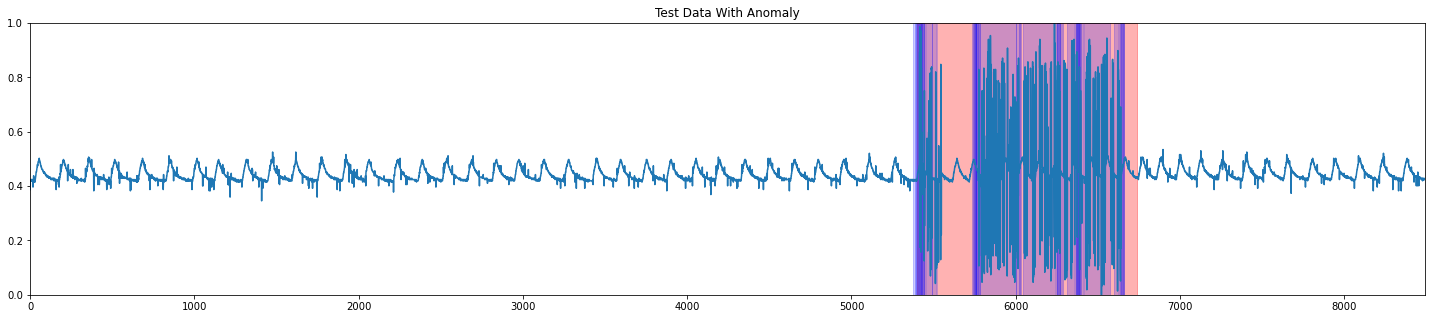

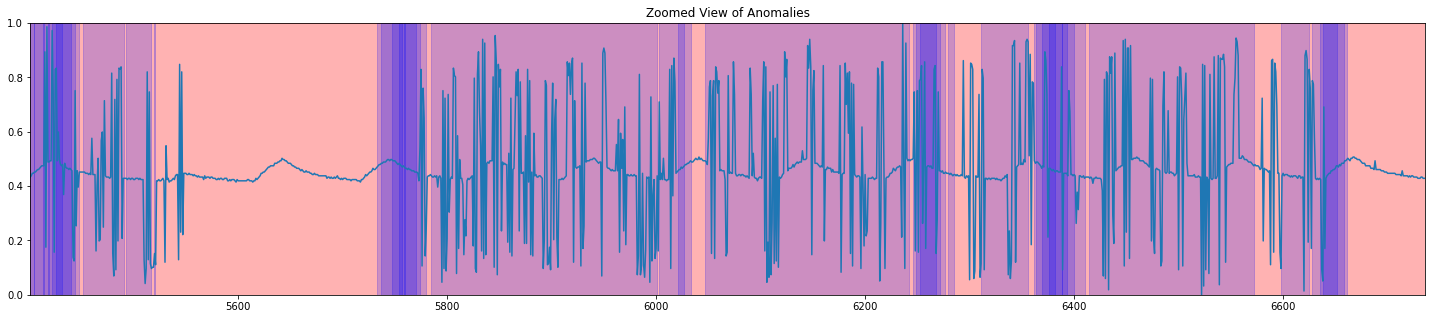

In [21]:
plt.figure(figsize=(25, 5))
plt.plot(points_test)
plt.ylim(0, 1)
plt.xlim(0, len(points_test))
plt.title("Test Data With Anomaly")
for n in range(0, len(anomaly_ranges)):
    plt.axvspan(anomaly_ranges[n][0], anomaly_ranges[n][1], color = 'red', alpha=0.3)
for n in range(0, len(anomaly_list)):
    plt.axvspan(anomaly_list[n][0], anomaly_list[n][1], color = 'blue', alpha=0.2)    
plt.show()

plt.figure(figsize=(25, 5))
plt.plot(points_test)
plt.ylim(0, 1)
plt.xlim(np.min(anomaly_ranges), np.max(anomaly_ranges))
plt.title("Zoomed View of Anomalies")
for n in range(0, len(anomaly_ranges)):
    plt.axvspan(anomaly_ranges[n][0], anomaly_ranges[n][1], color = 'red', alpha=0.3)
for n in anomaly_list:
    plt.axvspan(n[0], n[1], color = 'blue', alpha=0.2)
plt.show()

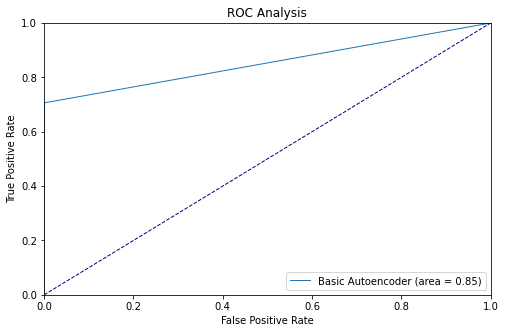

In [22]:
fpr, tpr, _ = roc_curve(y_test, anomalies)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
lw = 1
plt.plot(fpr, tpr,
         lw=lw, label='Basic Autoencoder (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

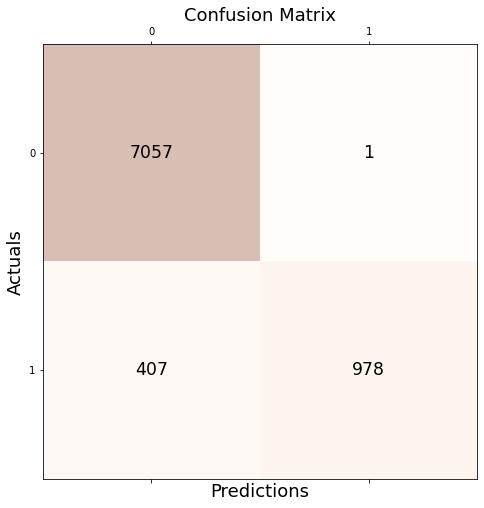

ROC Area: 0.853
F1 Score: 0.827
Accuracy: 0.952
Precision: 0.999
Recall: 0.706


In [23]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=anomalies)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('ROC Area: %.3f' % roc_auc)
print('F1 Score: %.3f' % f1_score(y_test, anomalies))
print('Accuracy: %.3f' % accuracy_score(y_test, anomalies))
print('Precision: %.3f' % precision_score(y_test, anomalies))
print('Recall: %.3f' % recall_score(y_test, anomalies))
